In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm
import random
from IPython.display import display

In [2]:
df = pd.read_csv('/Volumes/GoogleDrive-116698033185964814580/My Drive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name'] = df['name'].apply(lambda x: 'r: '+x)

df

,login,name
0,u: vim-sroberge,r: vimaec/g3d
1,u: vim-sroberge,r: vimaec/g3d
2,u: vim-sroberge,r: vimaec/g3d
3,u: vim-sroberge,r: vimaec/g3d
4,u: mavimaec,r: vimaec/g3d
...,...,...
1328,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1329,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1330,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples
1331,u: joe-tingsanchali-sonarsource,r: SonarSource/sonar-scanning-examples


In [3]:
# Build the adjacency matrix for user - repo (and repo - user) interactions.
adj_matrix = pd.crosstab(df['login'], df['name']).astype(float)
idx = adj_matrix.columns.union(adj_matrix.index)
adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

adj_matrix

,r: AkinJimoh/aj-soner,r: AkinJimoh/sonar-scan,r: CPWRGIT/HDDRXM0,r: CPWRGIT/HDDRXM02,r: CPWRGIT/HDDRXM0_CWC2,r: CPWRGIT/ISPWSA0,r: CPWRGIT/ISPWSA0_CWC2,r: Compuware-Corp/TotalTest-Test-Repo,r: DhineshPalanisamy/FintechAPP,r: Dxngaa/print-dxngaa,...,u: turboKittyNinja,u: ursinn,u: velivalab,u: vim-sroberge,u: waitesid,u: whitesource-bolt-for-github[bot],u: wilbertkho,u: willdoescode,u: writ3it,u: yyyxam
r: AkinJimoh/aj-soner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: AkinJimoh/sonar-scan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r: CPWRGIT/HDDRXM0_CWC2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
u: whitesource-bolt-for-github[bot],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: wilbertkho,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: willdoescode,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
u: writ3it,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# List user and repos
users = [x for x in adj_matrix.columns if x.startswith('u: ')]
repos = [x for x in adj_matrix.columns if x.startswith('r: ')]

print(f'Number of users: {len(users)}, number of repos: {len(repos)}')
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
print(f'Directed graph with {nx.number_of_nodes(G)} nodes, {nx.number_of_edges(G)} edges and {nx.number_weakly_connected_components(G)} components')

Number of users: 145, number of repos: 117
Directed graph with 262 nodes, 192 edges and 74 components


In [5]:
def user_user_similarity(adj_matrix, repos):

    ## Get repo - user similarity (upper-right square):
    repo_user = adj_matrix.iloc[:len(repos),len(repos):]
    repo_user = repo_user/np.linalg.norm(repo_user,axis=0,keepdims=True)
    repo_user[np.isnan(repo_user)] = 0
    repo_user = np.dot(repo_user.transpose(),repo_user)

    ## Get user - repo similarity (lower-left square):
    user_repo = adj_matrix.iloc[len(repos):,:len(repos)]
    user_repo = user_repo/np.linalg.norm(user_repo,axis=1,keepdims=True)
    user_repo[np.isnan(user_repo)] = 0
    user_repo = np.dot(user_repo, user_repo.transpose())

    # Combine upper and lower triangles, keep 0 in the diagonal.
    user_user = np.triu(repo_user,1) + np.tril(user_repo,-1)

    # return user_user
    return user_user 

adj_matrix.loc[users, users] = user_user_similarity(adj_matrix, repos)
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
print(f'Directed graph with {nx.number_of_nodes(G)} nodes, {nx.number_of_edges(G)} edges and {nx.number_weakly_connected_components(G)} components')

Directed graph with 262 nodes, 519 edges and 74 components


In [6]:
def mutate_vector(user_vect, max_value):
    # Set a random zero value to non-zero, one at a time.
    random = np.random.randint(0,len(user_vect))

    if 0 in user_vect.to_list():
        while user_vect.iloc[random] != 0:
            random = np.random.randint(0,len(user_vect))
        user_vect.iloc[random] = np.random.randint(1,max_value) # A value between 1 and max value


    # And, with 50% chance, sets a non-zero value to 0 or add random noise.
    chance = np.random.uniform(0,1)
    random = np.random.randint(0,len(user_vect))

    if not all(user_vect == 0):
        while user_vect.iloc[random] == 0:
            random = np.random.randint(0,len(user_vect))

        if chance > 0.5:
            # Add noise
            user_vect.iloc[random] = np.clip(user_vect.iloc[random] + np.random.choice([-1,1]) * np.random.randint(1,max_value),1,max_value)
        else:
            # Set to zero
            user_vect.iloc[random] = 0

    return user_vect

In [7]:
# Mutator, give it an adj_matrix, and it will return the mutated adj_matrix.

def mutate(adj_matrix, node, repos, users):

  # Create copies of adj_matrix and user node:
  am          = adj_matrix.copy()
  user_index  = am.loc[node][:len(repos)]
  user_column = am.loc[:,node][:len(repos)]

  # Mutate user node:
  max = am.max().max()
  am.loc[node][:len(repos)]   = mutate_vector(user_index, max)
  am.loc[:,node][:len(repos)] = mutate_vector(user_column, max)

  # Evaluate similarity:
  am.loc[users, users] = user_user_similarity(am, repos)
  
  return am

In [8]:
# Compute graph metrics, betweenness centrality and node degree

def graph_metrics(adj_matrix, centrality):

     G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

     # nx.eigenvector_centrality
     if centrality == nx.eigenvector_centrality:
          centrality_column = 'eigenvector_centrality'
          result = None
          i = 0
          tol = 1.0e-6
          while result is None:
               try:
                    result = {'degree' : {node:val for (node, val) in G.degree()},
                              centrality_column: nx.eigenvector_centrality(G, max_iter=i, tol=tol)}
               except nx.exception.PowerIterationFailedConvergence:
                    i += 500
                    if i > 1500:
                         tol = 1.0e-5

                    if i > 4500:
                         tol = 1.0e-4

                    if i > 9500:
                         tol = 1.0e-3
     
     # nx.betweenness_centrality
     if centrality == nx.betweenness_centrality:
          centrality_column = 'betweenness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column : centrality(G,normalized=False)}

     # nx.degree_centrality
     if centrality == nx.degree_centrality:
          centrality_column = 'degree_centrality'
          s = 1.0 / (len(G) - 1.0)
          result = nx.degree_centrality(G)
          result = {k: v/s for k,v in result.items()} # undo normalisation
          result = {centrality_column:result}
          aux = {'degree' : {node:val for (node, val) in G.degree()}}
          result = aux | result # merge dicts

     # nx.closeness_centrality
     if centrality == nx.closeness_centrality:
          centrality_column = 'closeness_centrality'
          result = {'degree' : {node:val for (node, val) in G.degree()} ,
                    centrality_column:nx.closeness_centrality(G, wf_improved=False)}

     # Dict to DataFrame, normalise values
     # normalise node degree values  https://www.statology.org/normalize-data-between-0-and-1/
     # zi = (xi – min(x)) / (max(x) – min(x))
     result = pd.DataFrame(result)
     result['degree'] = result['degree'].apply(lambda x: (x - result['degree'].min())/(result['degree'].max() - result['degree'].min()))
     result[centrality_column] = result[centrality_column].apply(lambda x: (x - result[centrality_column].min())/(result[centrality_column].max() - result[centrality_column].min()))

     # filter users
     result = result[result.index.str.startswith('u: ')]

     return result

In [9]:
# Evaluate metrics in terms of star-discrepancy

def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [10]:
# evolution strategy (mu, lambda) algorithm

def es_plus(initial_record, objective, n_iter, mu, lam, centrality):
  best, best_eval = None, 1e+10

  # number of repos and users:
  users = [x for x in adj_matrix.columns if x.startswith('u: ')]
  repos = [x for x in adj_matrix.columns if x.startswith('r: ')]

	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = initial_record.copy()       # copy the initial matrix
    population.append(candidate)            # add to population

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(graph_metrics(candidate,centrality)) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval, niter = population[i], scores[i], epoch
        #print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
        # keep the parent
        offspring.append(population[i])

        # create offspring for parent
        for j in range(n_children):

          sample = np.random.choice(users)
          child = mutate(population[i], sample, repos, users)
          offspring.append(child)

    # replace population with children
    population = offspring

  return [niter, best, best_eval]

In [11]:
def plot_results(ax, user_node, bot_node, adj_matrix, metric):

    ax = ax or plt.gca()

    metric_df = graph_metrics(adj_matrix, metric)

    ax.scatter(metric_df.iloc[:,0],metric_df.iloc[:,1],edgecolor="k", c="r")
    ax.set_xlabel('Degree')
    ax.set_ylabel(str(metric).split(' ')[1])
    ax.annotate('mike', (metric_df.loc[user_node][0], metric_df.loc[user_node][1]))
    ax.annotate('bot', (metric_df.loc[bot_node][0] - 0.05, metric_df.loc[bot_node][1]- 0.05))
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.text(0.5,-0.3,f'Star-discrepancy score: {objective(metric_df):.3f} \n',fontsize='large',horizontalalignment='center')
    plt.close()
    
    return ax

In [12]:
def plot_graph_comparison(initial_graph, final_graph, pos):

    d = {'Nodes':[nx.number_of_nodes(initial_graph),nx.number_of_nodes(final_graph)],
         'Edges':[nx.number_of_edges(initial_graph),nx.number_of_edges(final_graph)],
         'Components':[nx.number_weakly_connected_components(initial_graph), nx.number_weakly_connected_components(final_graph)]}

    display(pd.DataFrame(d, index=['G', 'N']))

    plt.figure(figsize=(10,5))
    plt.title('Initial Directed Graph G')

    plt.show()
    plt.close()
    plt.figure(figsize=(10,5))
    plt.title('Evolved Directed Graph N')
    color_map = ['b' if node.startswith('u: ') else 'y' for node in final_graph]
    nx.draw(final_graph, node_color=color_map, pos = pos)
    plt.show()
    plt.close()

In [13]:
def find_seed(n_seeds, adj_matrix, objective, n_iter, mu, lam, centrality):

    scores = {'seed':[],'iterations':[],'score':[],'nodes':[],'edges':[],'components':[]}

    for i in tqdm(range(n_seeds)):
        
        # set a seed
        np.random.seed(i)
        # define the total iterations
        n_iter = n_iter
        # number of parents selected
        mu = mu
        # the number of children generated by parents
        lam = lam
        # perform the evolution strategy (mu, lambda) search
        iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)
        # compute the resulting graph
        N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)
        # get the number of nodes, edges and connected components
        nodes, edges, components = nx.number_of_nodes(N), nx.number_of_edges(N), nx.number_weakly_connected_components(N)

        scores['iterations'].append(iterations)
        scores['seed'].append(i)
        scores['score'].append(score)
        scores['nodes'].append(nodes)
        scores['edges'].append(edges)
        scores['components'].append(components)

    return pd.DataFrame(scores)

## Experimental results:
### (1 + 1)-EA, New mutation strategy

In [14]:
# (1 + 1) betweenness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.betweenness_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


,seed,iterations,score,nodes,edges,components
72,72,13,0.620055,262,551,61
43,43,15,0.620809,262,572,55
23,23,8,0.622695,262,537,64
0,0,13,0.623353,262,548,59
17,17,2,0.627126,262,540,72
...,...,...,...,...,...,...
60,60,0,0.649914,262,519,74
62,62,0,0.649914,262,519,74
63,63,0,0.649914,262,519,74
71,71,0,0.649914,262,519,74


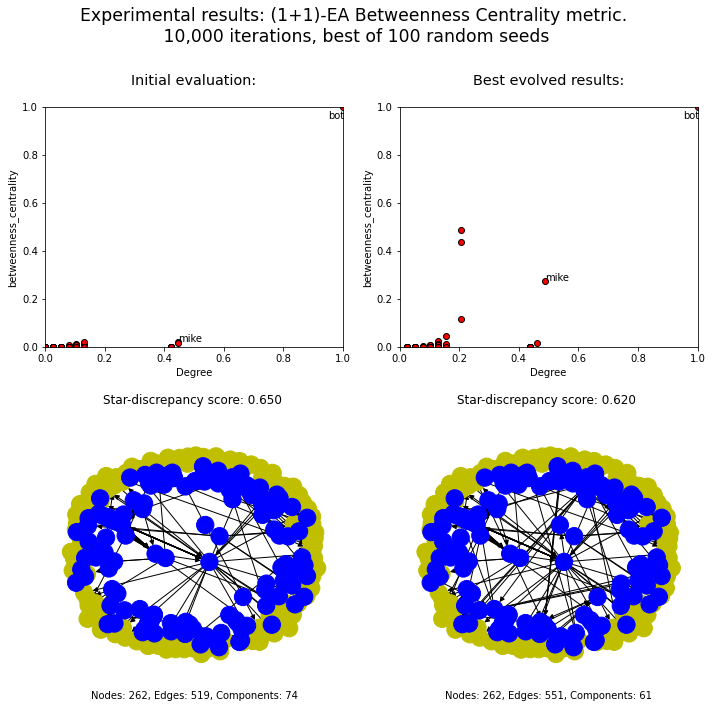

In [15]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# Set nodes position
pos = nx.spring_layout(G)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

In [16]:
# (1 + 1) closeness evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.closeness_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:35<00:00,  2.81it/s]


,seed,iterations,score,nodes,edges,components
0,0,7,0.290028,262,533,67
85,85,8,0.294048,262,536,66
72,72,7,0.298068,262,537,68
49,49,6,0.302617,262,548,69
37,37,9,0.305787,262,523,63
...,...,...,...,...,...,...
66,66,0,0.337715,262,519,74
34,34,0,0.337715,262,519,74
70,70,0,0.337715,262,519,74
20,20,0,0.337715,262,519,74


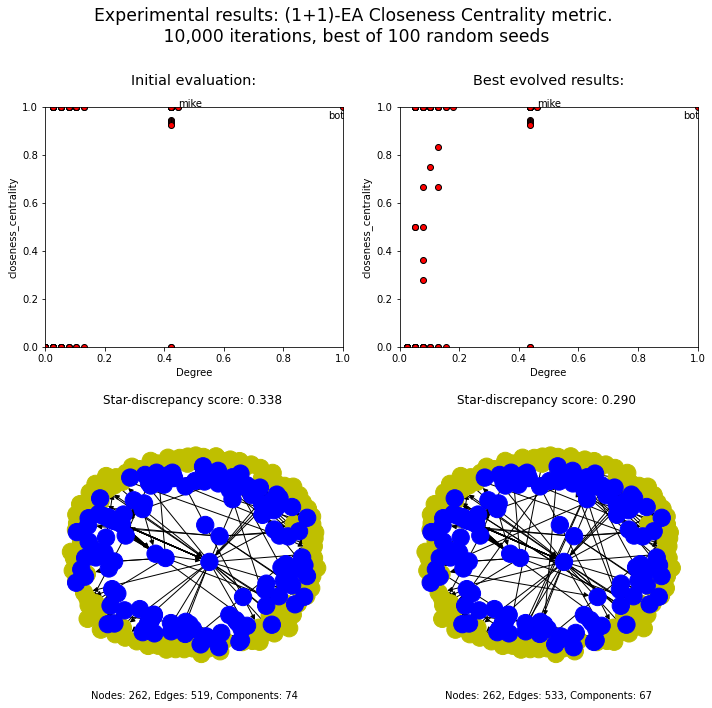

In [17]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

In [18]:
# (1 + 1) eignevector centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.eigenvector_centrality

scores = find_seed(seeds, adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


,seed,iterations,score,nodes,edges,components
43,43,15,0.620973,262,572,55
49,49,6,0.626089,262,548,69
4,4,11,0.627886,262,548,61
17,17,2,0.629224,262,540,72
0,0,13,0.630030,262,548,59
...,...,...,...,...,...,...
75,75,0,0.649973,262,519,74
33,33,0,0.649973,262,519,74
77,77,0,0.649973,262,519,74
30,30,0,0.649973,262,519,74


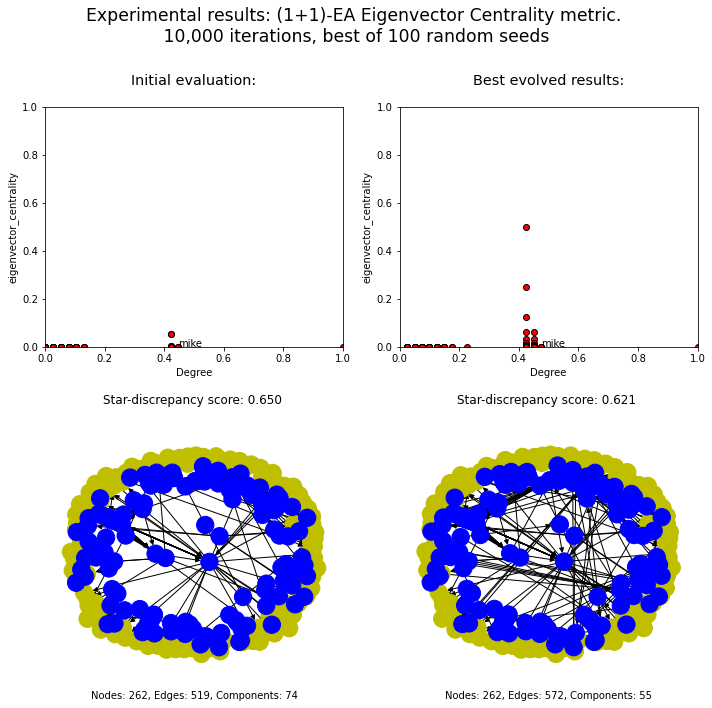

In [19]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

## Experimental results:
### G = Connected graph
Add edges between connected components until end up with one weakly connected graph, i.e. a graph where all its nodes are connected in at least one direction.

In [20]:
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
connected_components = list(nx.weakly_connected_components(G))

users_connected_components = list()
repos_connected_components = list()

for component in connected_components:

    users_aux = list()
    repos_aux = list()

    for node in component:
        if node.startswith('u: '):
            users_aux.append(node)
        else:
            repos_aux.append(node)

    users_connected_components.append(users_aux)
    repos_connected_components.append(repos_aux)

# Send first component to the last place:
repos_connected_components.append(repos_connected_components.pop(0))


for users, repos in zip(users_connected_components,repos_connected_components):
    user = random.choice(users)
    repo = random.choice(repos)
    G.add_edge(user, repo)
    G.add_edge(repo, user)

print(f'Is weakly connected\t\t\t = {nx.is_weakly_connected(G)}, \nNumber of weakly connected components\t = {nx.number_weakly_connected_components(G)}')

Is weakly connected			 = True, 
Number of weakly connected components	 = 1


In [21]:
conencted_adj_matrix = nx.to_pandas_adjacency(G)

In [22]:
# (1 + 1) betweeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.betweenness_centrality

scores = find_seed(seeds, conencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


,seed,iterations,score,nodes,edges,components
26,26,2,0.224974,262,788,1
65,65,3,0.252964,262,789,1
95,95,1,0.255314,262,789,1
22,22,2,0.262230,262,788,1
23,23,2,0.263755,262,792,1
...,...,...,...,...,...,...
59,59,0,0.292292,262,667,1
60,60,0,0.292292,262,667,1
61,61,0,0.292292,262,667,1
69,69,0,0.292292,262,667,1


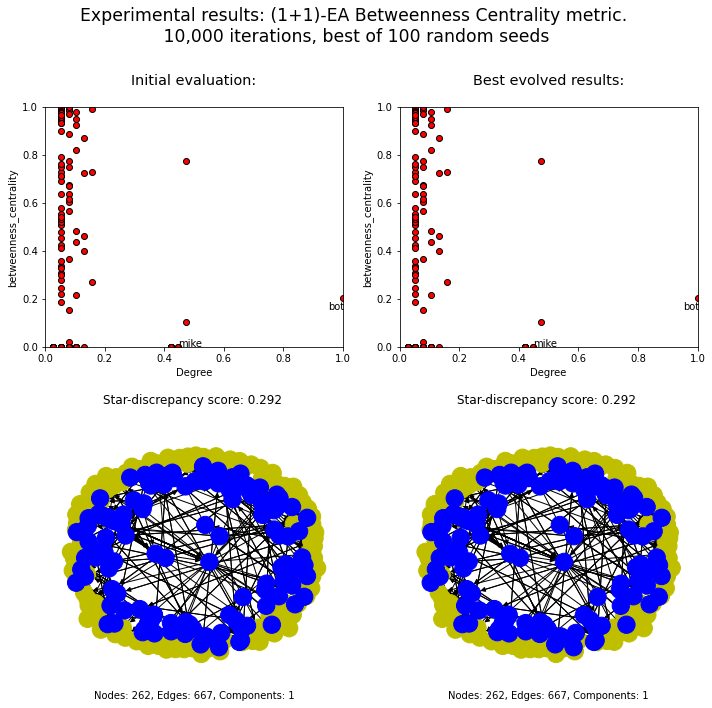

In [23]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(conencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(conencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', conencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

In [24]:
# (1 + 1) closeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.closeness_centrality

scores = find_seed(seeds, conencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


,seed,iterations,score,nodes,edges,components
86,86,4,0.412703,262,775,1
85,85,3,0.450065,262,795,1
93,93,9,0.460611,262,815,1
31,31,4,0.462076,262,797,1
17,17,1,0.464701,262,803,1
...,...,...,...,...,...,...
60,60,0,0.515805,262,667,1
66,66,0,0.515805,262,667,1
68,68,0,0.515805,262,667,1
77,77,0,0.515805,262,667,1


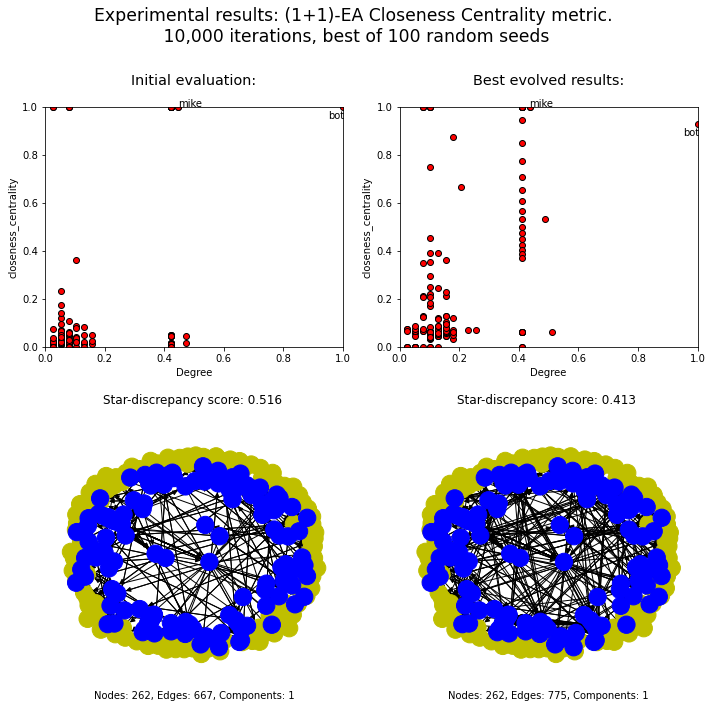

In [25]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(conencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(conencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', conencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

In [26]:
# (1 + 1) eigenvector centrality evaluation:

seeds, n_iter, mu, lam, centrality = 100, 10000, 1, 1, nx.eigenvector_centrality

scores = find_seed(seeds, conencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 100/100 [02:53<00:00,  1.73s/it]


,seed,iterations,score,nodes,edges,components
95,95,9,0.570324,262,804,2
82,82,10,0.571928,262,831,1
54,54,6,0.572713,262,821,1
94,94,14,0.572985,262,833,1
42,42,4,0.573560,262,777,2
...,...,...,...,...,...,...
27,27,1,0.590010,262,787,1
10,10,1,0.590278,262,787,1
79,79,1,0.590630,262,783,1
26,26,2,0.590944,262,775,1


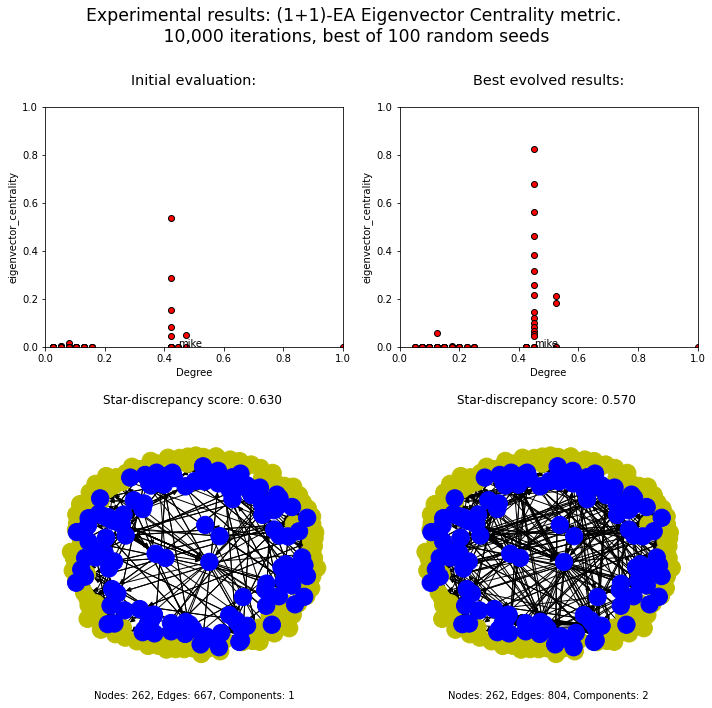

In [28]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(conencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(conencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', conencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

## Experimental results:
### Connected graph and increased population

In [29]:
# (1 + 20) betweeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.betweenness_centrality

scores = find_seed(seeds, conencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [01:46<00:00, 10.61s/it]


,seed,iterations,score,nodes,edges,components
6,6,10,0.219501,262,809,2
9,9,3,0.228436,262,793,2
0,0,5,0.236772,262,797,1
7,7,8,0.237743,262,801,1
1,1,3,0.254577,262,787,1
4,4,4,0.258650,262,792,2
3,3,5,0.261512,262,800,2
8,8,4,0.265117,262,795,1
5,5,1,0.266120,262,789,1
2,2,3,0.271217,262,786,1


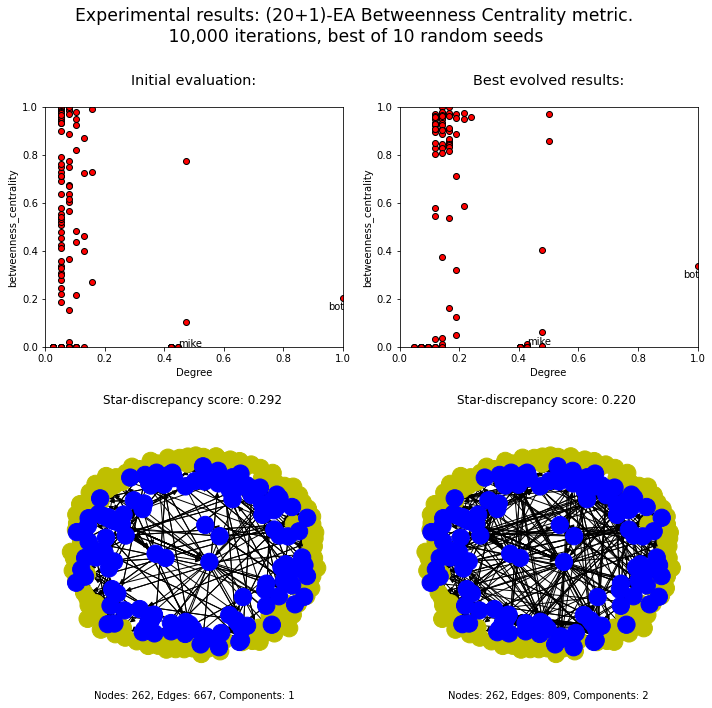

In [30]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(conencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(conencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', conencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

In [31]:
# (1 + 20) closeness centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.closeness_centrality

scores = find_seed(seeds, conencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [07:22<00:00, 44.30s/it]


,seed,iterations,score,nodes,edges,components
8,8,122,0.081851,262,1248,3
6,6,59,0.118935,262,960,2
7,7,54,0.131930,262,923,2
1,1,36,0.234573,262,863,3
2,2,20,0.252369,262,853,2
3,3,18,0.255095,262,797,2
4,4,28,0.263533,262,837,2
9,9,28,0.266704,262,874,3
0,0,32,0.274657,262,870,3
5,5,18,0.299584,262,853,4


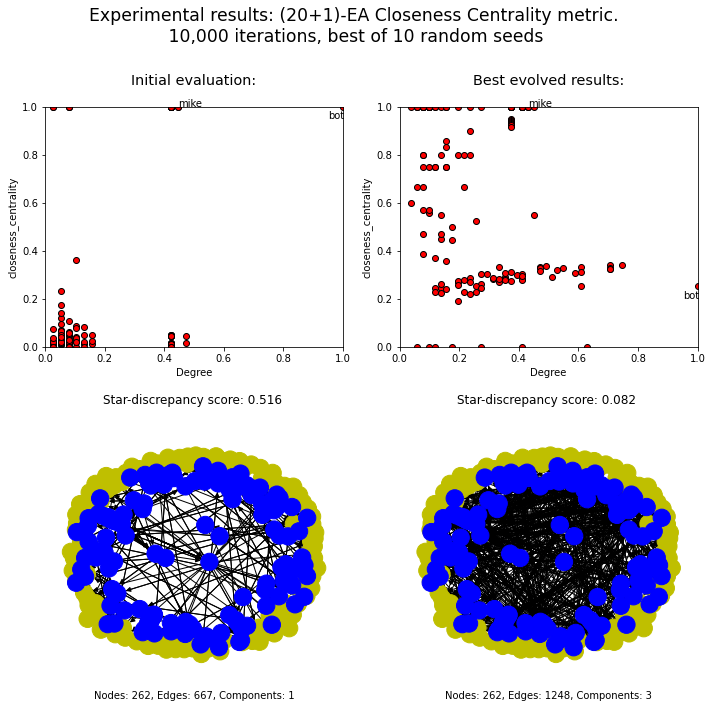

In [32]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(conencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(conencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', conencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

In [33]:
# (1 + 20) eigenvector centrality evaluation:

seeds, n_iter, mu, lam, centrality = 10, 10000, 1, 20, nx.eigenvector_centrality

scores = find_seed(seeds, conencted_adj_matrix, objective, n_iter, mu, lam, centrality)
scores.sort_values('score')

100%|██████████| 10/10 [24:45<00:00, 148.50s/it]


,seed,iterations,score,nodes,edges,components
3,3,190,0.027675,262,1833,1
6,6,228,0.034690,262,2173,1
5,5,197,0.042306,262,2007,2
4,4,199,0.052104,262,1930,2
7,7,159,0.056726,262,1604,4
9,9,165,0.060674,262,1824,4
8,8,136,0.091783,262,1561,2
2,2,106,0.174306,262,1272,3
1,1,42,0.321056,262,887,2
0,0,38,0.321588,262,870,2


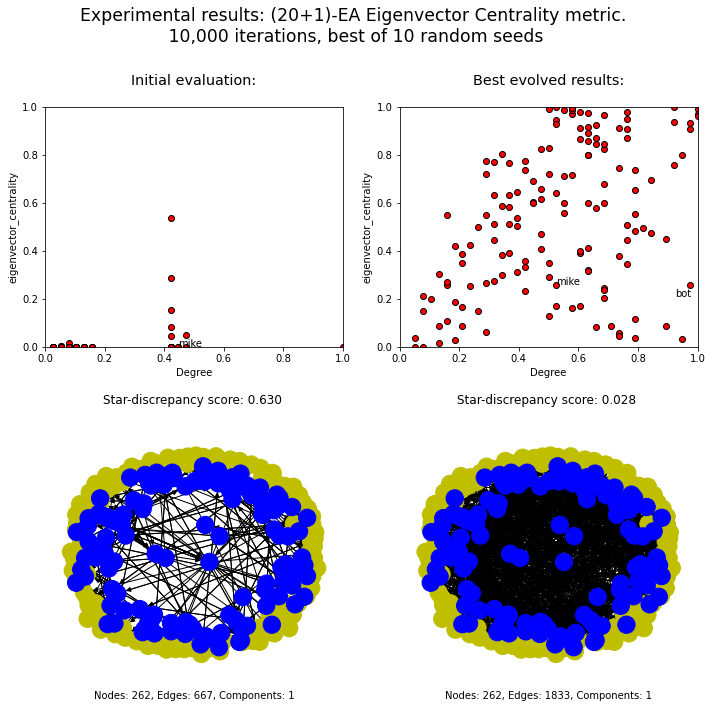

In [34]:
# set the best seed
np.random.seed(scores[scores['score'] == scores['score'].min()]['seed'])

# perform the evolution strategy (mu, lambda) search
iterations, best, score = es_plus(conencted_adj_matrix, objective, n_iter, mu, lam, centrality)

# Initial graph G
G = nx.from_pandas_adjacency(conencted_adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)

# plot results
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,10))
ax1.set_title('Initial evaluation:\n',fontsize='x-large')
ax2.set_title('Best evolved results:\n',fontsize='x-large')
plot_results(ax1,'u: mikeharrisontelia','u: dependabot[bot]', conencted_adj_matrix, centrality)
plot_results(ax2,'u: mikeharrisontelia','u: dependabot[bot]', best, centrality)
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos, ax=ax3)
nx.draw(N, node_color=color_map, pos = pos, ax=ax4)
ax3.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(G)}, Edges: {nx.number_of_edges(G)}, Components: {nx.number_weakly_connected_components(G)}', ha='center', transform=ax3.transAxes)
ax4.text(0.5,-0.1,f'Nodes: {nx.number_of_nodes(N)}, Edges: {nx.number_of_edges(N)}, Components: {nx.number_weakly_connected_components(N)}', ha='center', transform=ax4.transAxes)
fig.suptitle(f"Experimental results: ({lam}+{mu})-EA {str(centrality).split(' ')[1].replace('_', ' ').title()} metric. \n {n_iter:,} iterations, best of {seeds:,} random seeds \n",fontsize='xx-large')
fig.tight_layout()
fig

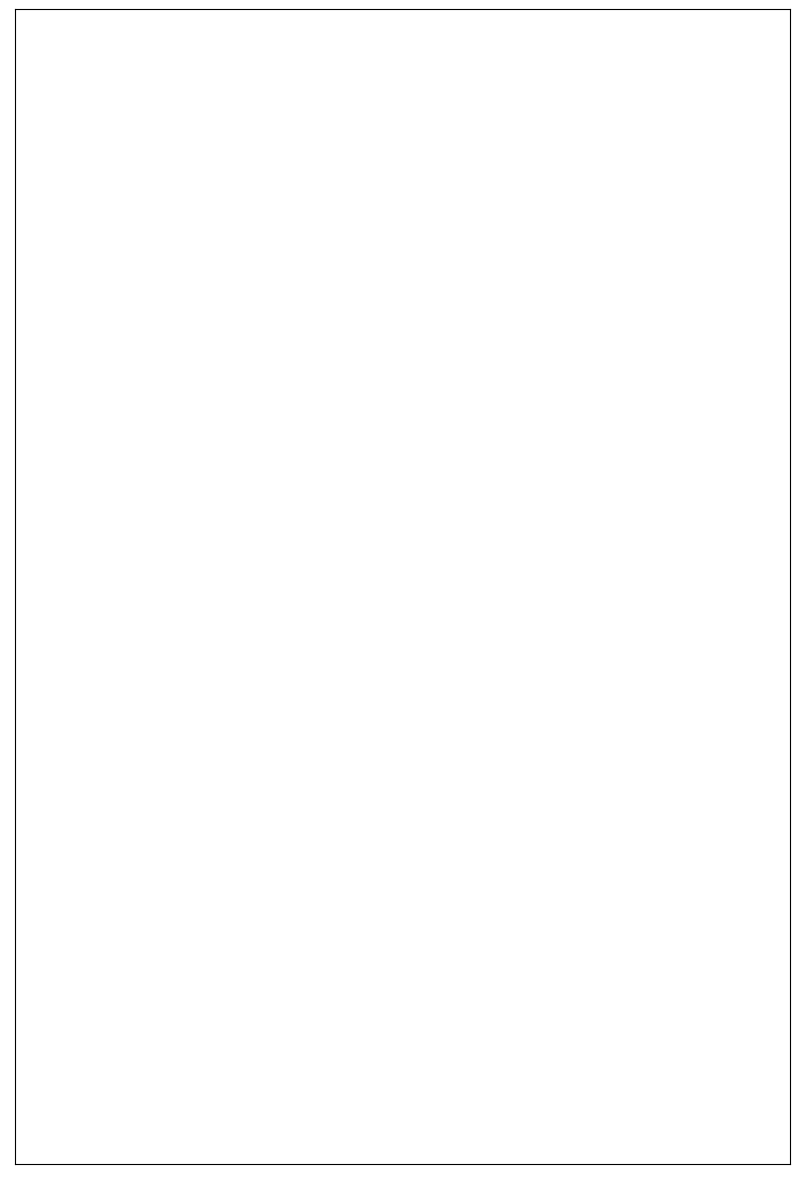

In [53]:
plt.style.use('default')
fig, ax = plt.subplots(1,1,figsize=(10,15))
#ax.text(0.5, 0.5, "Experimental results:\n (20 + 1)-EA, Connected graph", ha="center", va="center", fontsize='xx-large')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [50]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']